<a href="https://colab.research.google.com/github/gabsgeografo/InteligenciaArtificialMestrado/blob/main/CNN_com_3_blocos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Criação do dataset - Base de imagens

Importação das bibliotecas e criação das pastas para treinamento

In [ ]:
import os
from random import seed
from random import random
from shutil import copyfile
from os import makedirs
from os import listdir

from google.colab import drive
drive.mount('/content/drive')

def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

criar_diretorio('IA')
criar_diretorio('IA/Images')

Mounted at /content/drive


In [ ]:
!cp -r  /content/drive/Othercomputers/Meu\ laptop/Relatorio/Novas/IA/Novas /content/IA/Images

In [ ]:
#conferencia da copia das imagens
import os
initial_count = 0
dir = "/content/IA/Images/Novas"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)

1008


Com base no nome das imagens, as mesmas foram dividas em dois grupos: 

Fita e Classes

Neste bloco é criada a estrutura das pastas separando em Classe e Fita.

Objetivo da rede: idenficar o que é Classe e o que é Fita

A base entre Train (Treinamento) e Test (Teste) foi dividida aleatóriamente em 30% teste e 70% treinamento.

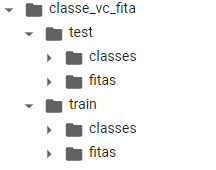

In [ ]:
#batch_size = 64
#num_classes = 10
#epochs = 10

#cria estrutura de arquivos
dataset_home = 'classe_vc_fita/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['classes/', 'fitas/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.3
# copy training dataset images into subdirectories

folder = '/content/IA/Images/Novas/'

src_directory = folder #'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('classe'):
		dst = dataset_home + dst_dir + 'classes/'  + file
		copyfile(src, dst)
	elif file.startswith('fita'):
		dst = dataset_home + dst_dir + 'fitas/'  + file
		copyfile(src, dst)  

VGG-Block

Importação das bibliotecas para montagem de uma rede CNN com 3 camadas (swallow)

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import regularizers
from keras.models import Model

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.utils import plot_model

Função para montar o gráfico de acurácia

In [ ]:
def summarize_diagnostics(history):
	#pyplot.subplot(211)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.legend()

	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('plot.png')
	pyplot.close()

Teste 1:

CNN com:

Três blocos de camadas de convolução e Função de ativação Tanh.

1.   Bloco 1:
  2 camadas com 32 filtros seguida de um MaxPolling2D (2x2)
2.   Bloco 2:
  2 camadas com 64 filtros seguida de um MaxPolling2D (2x2)
3.   Bloco 2:
  2 camadas com 126 filtros seguida de um MaxPolling2D (2x2)

Uma camada densa com 512 filtros e função de ativação Relu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                    

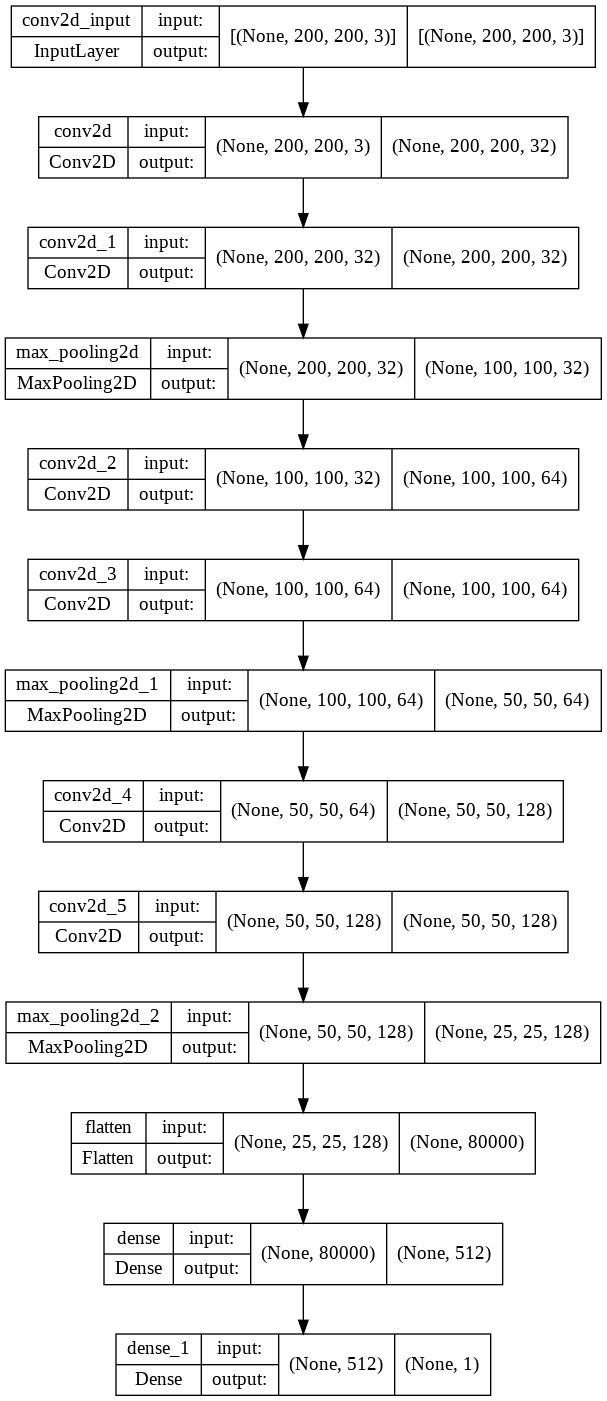

In [ ]:
model=Sequential()

# 1o. bloco de camadas
model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu', input_shape=(200, 200, 3)))
model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2o. bloco de camadas
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3o. bloco de camadas
model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

Carrega dataset com dados de Treinamento e Teste

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('classe_vc_fita/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('classe_vc_fita/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 726 images belonging to 2 classes.
Found 282 images belonging to 2 classes.


Treinar a rede com 10, 20 e 50 épocas

In [ ]:
history = model.fit(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1, )

Epoch 1/20
12/12 [==============================] - 25s 882ms/step - loss: 1848.8445 - accuracy: 0.6074 - val_loss: 38.4068 - val_accuracy: 0.2872
Epoch 2/20
12/12 [==============================] - 9s 779ms/step - loss: 10.4043 - accuracy: 0.4325 - val_loss: 0.7765 - val_accuracy: 0.6135
Epoch 3/20
12/12 [==============================] - 10s 852ms/step - loss: 0.5817 - accuracy: 0.7163 - val_loss: 0.5007 - val_accuracy: 0.7340
Epoch 4/20
12/12 [==============================] - 9s 760ms/step - loss: 0.4074 - accuracy: 0.7865 - val_loss: 0.4890 - val_accuracy: 0.7305
Epoch 5/20
12/12 [==============================] - 9s 714ms/step - loss: 0.2916 - accuracy: 0.8760 - val_loss: 0.5353 - val_accuracy: 0.7447
Epoch 6/20
12/12 [==============================] - 8s 726ms/step - loss: 0.2233 - accuracy: 0.9174 - val_loss: 0.5494 - val_accuracy: 0.7234
Epoch 7/20
12/12 [==============================] - 8s 679ms/step - loss: 0.1987 - accuracy: 0.9242 - val_loss: 0.6466 - val_accuracy: 0.7801

In [ ]:
from matplotlib import pyplot

def summarize_diagnostics(history):

	#pyplot.subplot(211)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.legend()

	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('plot_3_camadas_32_64_128_512.png')
	pyplot.close()

summarize_diagnostics(history)

qer, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

5/5 [==============================] - 2s 380ms/step - loss: 1.2043 - accuracy: 0.8156
> 81.560


RESULTADOS DO TESTE 1

Com 10 épocas o resultado foi:

Acurácia de 77,6% e o tempo de processamento foi de 01:52 min.

Gráfico Acurácia
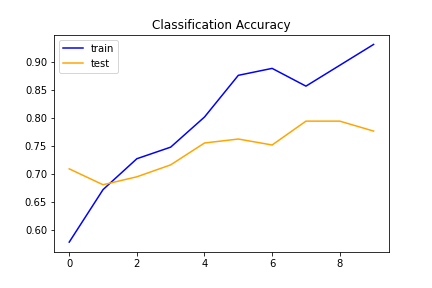

Com 20 épocas o resultado foi:

Acurácia de 81,5% e tempo de processamento de 03:00 min

Gráfico Acurácia
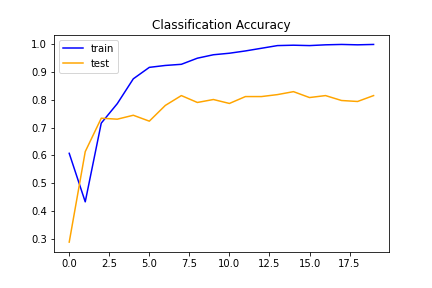

Com 50 épocas o resultado foi:

Acurácia de 82,2% e o tempo de processamento foi de 06:45 min.

Gráfico Acurácia
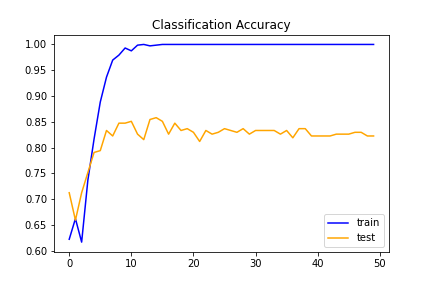

In [ ]:

# prepare iterator
#train_it = datagen.flow_from_directory('finalize_classe_vs_fita/', class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
#model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=20, verbose=0)
	# save model
model.save('best_model_3camada2conv_73799.h5')
!cp -r /content/best_model_3camada2conv_73799.h5 /content/drive/Othercomputers/Meu\ laptop/Artigo

Teste 2:

CNN com 3 blocos de camadas de convolução e Função de ativação Tanh.

1.   Bloco 1:
  1 camadas com 32 filtros seguida de um MaxPolling2D
2.   Bloco 2:
  1 camadas com 64 filtros seguida de um MaxPolling2D
3.   Bloco 2:
  1 camadas com 126 filtros seguida de um MaxPolling2D

Com uma camada densa com 512 filtros e função de ativação Relu


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 128)      0

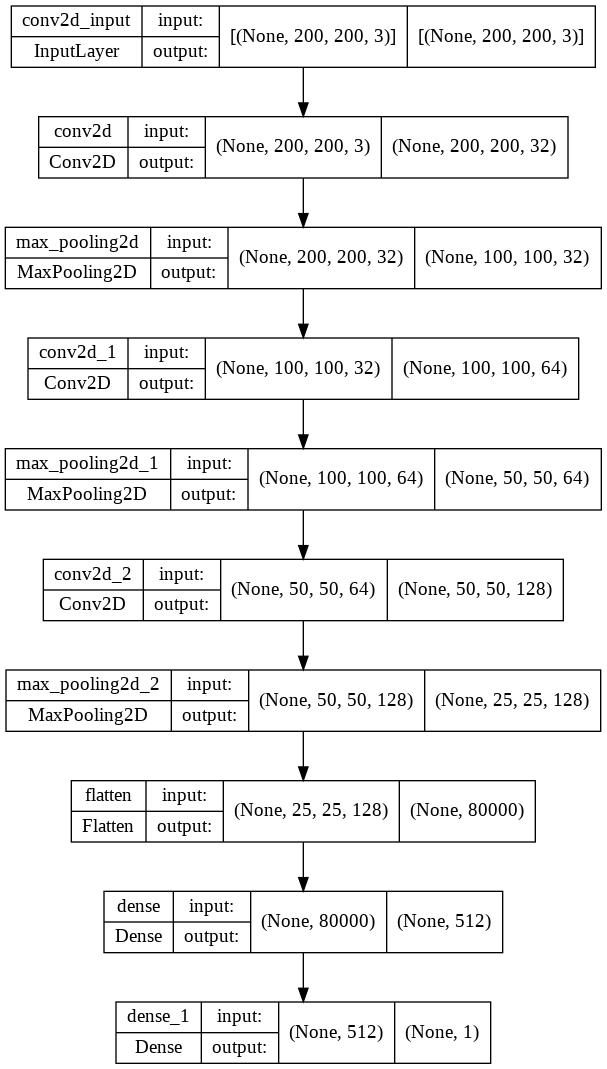

In [ ]:
from tensorflow.keras.optimizers import SGD

model=Sequential()

# 1o. bloco de camadas
model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2o. bloco de camadas
model.add(Conv2D(64, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3o. bloco de camadas
model.add(Conv2D(128, (3,3), kernel_initializer='he_uniform', padding='same', activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='multiple_vgg_blocks.png')

In [ ]:
history = model.fit(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1, )

Epoch 1/20
12/12 [==============================] - 23s 891ms/step - loss: 4785.8403 - accuracy: 0.6047 - val_loss: 108.2135 - val_accuracy: 0.7128
Epoch 2/20
12/12 [==============================] - 7s 619ms/step - loss: 30.1985 - accuracy: 0.6749 - val_loss: 3.9252 - val_accuracy: 0.7376
Epoch 3/20
12/12 [==============================] - 8s 749ms/step - loss: 1.1814 - accuracy: 0.8099 - val_loss: 0.9852 - val_accuracy: 0.7801
Epoch 4/20
12/12 [==============================] - 7s 662ms/step - loss: 0.2262 - accuracy: 0.9174 - val_loss: 0.7674 - val_accuracy: 0.7730
Epoch 5/20
12/12 [==============================] - 7s 619ms/step - loss: 0.1003 - accuracy: 0.9669 - val_loss: 0.7591 - val_accuracy: 0.7837
Epoch 6/20
12/12 [==============================] - 7s 653ms/step - loss: 0.0632 - accuracy: 0.9752 - val_loss: 0.9271 - val_accuracy: 0.7766
Epoch 7/20
12/12 [==============================] - 7s 623ms/step - loss: 0.0437 - accuracy: 0.9780 - val_loss: 1.0580 - val_accuracy: 0.7908

In [ ]:
from matplotlib import pyplot

def summarize_diagnostics(history):

	#pyplot.subplot(211)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.legend()

	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	pyplot.savefig('plot_3_camadas_simples_32_64_128_512_20.png')
	pyplot.close()

summarize_diagnostics(history)

qer, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

5/5 [==============================] - 2s 380ms/step - loss: 1.7344 - accuracy: 0.7730
> 77.305


RESULTADO TESTE 2

Com 10 épocas o resultado foi:

Acurácia de 78% e o tempo de processamento foi de 01:06 min.

Gráfico Acurácia
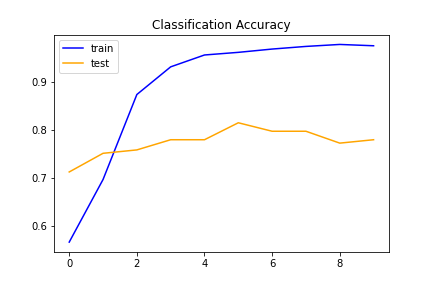

Com 20 épocas o resultado foi:

Acurácia de 77.3% e o tempo de processamento foi de 02:25 min.

Gráfico Acurácia
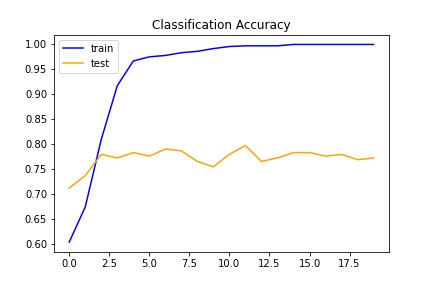

Com 50 épocas o resultado foi:

Acurácia de 80.8% e o tempo de processamento foi de 06:22 min.

Gráfico Acurácia 
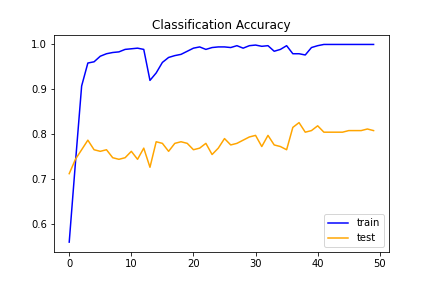